# Getaround – Delay Analysis

In this notebook, we analyze rental delays and their impact on back-to-back bookings.
The goals are:
- to understand how often drivers are late or early,
- to measure when a late return actually impacts the next rental,
- to evaluate different minimum time-gap thresholds between rentals,
- and to provide recommendations to the Product team about the optimal buffer.


# Import des librairies

In [190]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Explory Data Analysis

In [191]:
df = pd.read_excel("get_around_delay_analysis.xlsx")

In [192]:
df.describe(include="all")

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
count,21310.000000,21310.000000,21310,21310,16346.000000,1841.000000,1841.000000
unique,NaN,NaN,2,2,NaN,NaN,NaN
top,NaN,NaN,mobile,ended,NaN,NaN,NaN
freq,NaN,NaN,17003,18045,NaN,NaN,NaN
mean,549712.880338,350030.603426,NaN,NaN,59.701517,550127.411733,279.288430
std,13863.446964,58206.249765,NaN,NaN,1002.561635,13184.023111,254.594486
min,504806.000000,159250.000000,NaN,NaN,-22433.000000,505628.000000,0.000000
25%,540613.250000,317639.000000,NaN,NaN,-36.000000,540896.000000,60.000000
50%,550350.000000,368717.000000,NaN,NaN,9.000000,550567.000000,180.000000
75%,560468.500000,394928.000000,NaN,NaN,67.000000,560823.000000,540.000000


In [193]:
print("Nombre de voitures :", df["car_id"].nunique())

Nombre de voitures : 8143


In [194]:
print("Nombre de commandes :", df["rental_id"].nunique())

Nombre de commandes : 21310


In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21310 entries, 0 to 21309
Data columns (total 7 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rental_id                                   21310 non-null  int64  
 1   car_id                                      21310 non-null  int64  
 2   checkin_type                                21310 non-null  object 
 3   state                                       21310 non-null  object 
 4   delay_at_checkout_in_minutes                16346 non-null  float64
 5   previous_ended_rental_id                    1841 non-null   float64
 6   time_delta_with_previous_rental_in_minutes  1841 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.1+ MB


In [196]:
df.sample(50)

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
3689,518635,271617,mobile,ended,10.0,NaN,NaN
28,522602,391287,mobile,ended,35.0,NaN,NaN
18265,559613,405140,mobile,ended,-710.0,NaN,NaN
7848,539009,392327,mobile,ended,274.0,521664.0,600.0
8612,537466,350433,mobile,ended,96.0,NaN,NaN
30,523800,352799,mobile,ended,-345.0,NaN,NaN
15733,545897,382059,mobile,ended,NaN,NaN,NaN
3117,530747,239754,mobile,ended,4.0,NaN,NaN
20807,553547,323762,mobile,ended,-49.0,NaN,NaN
1600,537372,405889,mobile,ended,-153.0,NaN,NaN


In [220]:
# === Summary of conflict statistics ===

# Total rentals
total_rentals = len(df)

# Finished rentals with delay info
df_delay = df[(df["state"] == "ended") & (df["delay_at_checkout_in_minutes"].notna())].copy()

# Merge previous rental delay
df_merge = df_delay.merge(
    df_delay[["rental_id", "delay_at_checkout_in_minutes"]],
    left_on="previous_ended_rental_id",
    right_on="rental_id",
    how="left",
    suffixes=("", "_previous")
)

# Keep only rentals with a previous rental (< 12h)
df_chain = df_merge[df_merge["delay_at_checkout_in_minutes_previous"].notna()].copy()
total_chains = len(df_chain)

# Identify true conflicts
df_chain["problematic"] = (
    df_chain["delay_at_checkout_in_minutes_previous"] >
    df_chain["time_delta_with_previous_rental_in_minutes"]
)

problematic_count = df_chain["problematic"].sum()

# Rates
rate_all = round(problematic_count / total_rentals * 100, 2)
rate_chain = round(problematic_count / total_chains * 100, 2)

# Build summary table
summary_df = pd.DataFrame({
    "Metric": [
        "Total rentals",
        "Chain rentals (<12h gap)",
        "Actual conflicts",
        "Conflict rate (over all rentals)",
        "Conflict rate (over chain rentals)"
    ],
    "Value": [
        total_rentals,
        total_chains,
        problematic_count,
        f"{rate_all}%",
        f"{rate_chain}%"
    ]
})

summary_df.style.set_properties(**{"font-size": "14px"})


,Metric,Value
0,Total rentals,21310
1,Chain rentals (<12h gap),1476
2,Actual conflicts,172
3,Conflict rate (over all rentals),0.81%
4,Conflict rate (over chain rentals),11.65%


The full dataset covers more than 21,000 bookings.
Only 1476 rentals were close enough to the previous one to potentially be impacted by a delay.
That’s 7% of all rentals.
Out of these 1476 chain rentals, 172 were true conflicts: the previous driver was late more than the gap before the next rental.
Across all 21,310 rentals, only 0.81% create a real customer-impacting conflict. This is very small in absolute terms.
But among the 1476 tightly chained rentals, 11.65% actually break the schedule. This is high, and it’s the “true risk zone” where operational friction happens.

## Reservation Distribution by Check-in Type

Number of reservations by check-in type:
- mobile: 17003 (79.8%)
- connect: 4307 (20.2%)


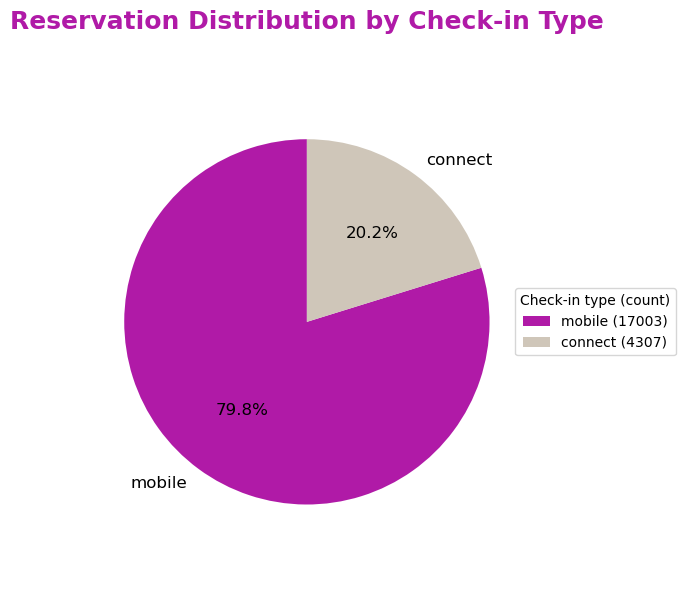

In [197]:
# Count reservations by check-in type
counts = df["checkin_type"].value_counts()
labels = counts.index
sizes = counts.values

# Compute percentages
percentages = sizes / sizes.sum() * 100

print("Number of reservations by check-in type:")
for label, count, pct in zip(labels, sizes, percentages):
    print(f"- {label}: {count} ({pct:.1f}%)")

# Colors (Getaround violet + soft contrasting color)
colors = ["#b01aa7", "#CFC6B9"]  # violet + soft orange

# Create pie chart
fig, ax = plt.subplots(figsize=(6, 6))

wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    textprops={"fontsize": 12}
)

ax.axis("equal")  # Ensure the pie is perfectly round

# Legend with total number of reservations
legend_labels = [f"{lab} ({cnt})" for lab, cnt in zip(labels, sizes)]
ax.legend(
    wedges,
    legend_labels,
    title="Check-in type (count)",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.title("Reservation Distribution by Check-in Type", fontsize=18, fontweight="bold", color="#B01AA7", pad=25)
plt.tight_layout()
plt.show()


Mobile check-ins clearly dominate the platform, representing 79.8% of all reservations. Connect check-ins account for the remaining share.
This means most rentals still rely on in-person interactions, suggesting that delays and coordination issues are more likely to occur within the mobile flow than the connect flow.

## Rental State Distribution (Ended vs Canceled)

Number of rentals by state:
- ended: 18045 (84.7%)
- canceled: 3265 (15.3%)


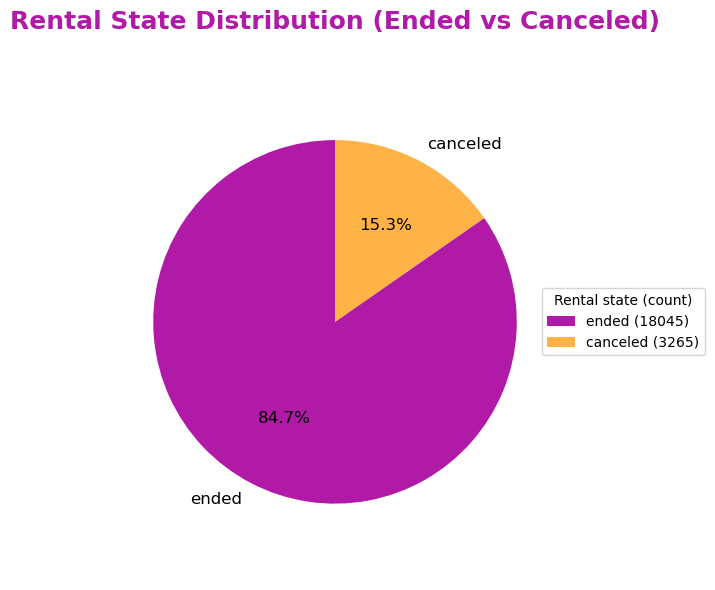

In [198]:
# Count rentals by state (ended vs canceled)
state_counts = df["state"].value_counts()
labels = state_counts.index
sizes = state_counts.values

# Compute percentages
percentages = sizes / sizes.sum() * 100

print("Number of rentals by state:")
for label, count, pct in zip(labels, sizes, percentages):
    print(f"- {label}: {count} ({pct:.1f}%)")

# Colors (violet Getaround + soft contrasting color)
colors = ["#B01AA7", "#FFB347"]  # violet + soft orange

# Create pie chart
fig, ax = plt.subplots(figsize=(6, 6))

wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    textprops={"fontsize": 12}
)

ax.axis("equal")  # Ensure the pie is perfectly round

# Legend with counts
legend_labels = [f"{lab} ({cnt})" for lab, cnt in zip(labels, sizes)]
ax.legend(
    wedges,
    legend_labels,
    title="Rental state (count)",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

# Title in Getaround violet
plt.title(
    "Rental State Distribution (Ended vs Canceled)",
    fontsize=18,
    fontweight="bold",
    color="#B01AA7",
    pad=25
)

plt.tight_layout()
plt.show()


This pie chart shows the share of rentals that were successfully completed ("ended") versus those that were canceled.

It helps quantify how many rentals actually take place, which is important when analyzing delays: only rentals in the "ended" category can generate checkout delays.

Canceled rentals do not contribute to delay issues and will be excluded from most of the analysis that follows.


## Checkout Outcomes (Early / On-time / Late)

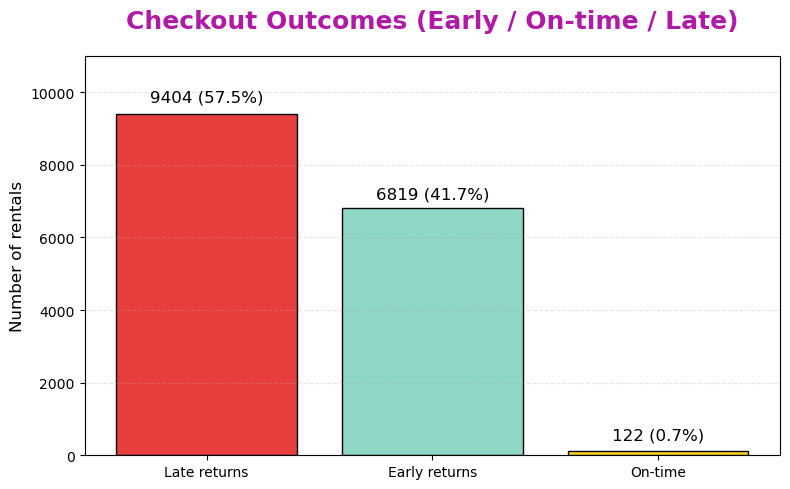

In [199]:
# Compute categories
df_delay = df[df["state"] == "ended"].copy()
df_delay = df_delay[df_delay["delay_at_checkout_in_minutes"].notna()]

early_returns = (df_delay["delay_at_checkout_in_minutes"] < 0).sum()
on_time = (df_delay["delay_at_checkout_in_minutes"] == 0).sum()
late_returns = (df_delay["delay_at_checkout_in_minutes"] > 0).sum()

categories = ["Early returns", "On-time", "Late returns"]
values = [early_returns, on_time, late_returns]

# Compute percentages
total = sum(values)
percentages = [v / total * 100 for v in values]

# Sort by descending order
sorted_data = sorted(zip(categories, values, percentages), key=lambda x: x[1], reverse=True)
sorted_categories, sorted_values, sorted_percentages = zip(*sorted_data)

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(sorted_categories, sorted_values,
               color=["#E93E3E", "#90D6C6", "#FFD723"],
               edgecolor="black")

# Title
plt.title(
    "Checkout Outcomes (Early / On-time / Late)",
    fontsize=18,
    fontweight="bold",
    color="#B01AA7",
    pad=20
)

plt.ylabel("Number of rentals", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.3)

# Y-axis limit up to 11,000 rentals
plt.ylim(0, 11000)

# Add values + percentages above bars
for bar, value, pct in zip(bars, sorted_values, sorted_percentages):
    height = bar.get_height()

    # Default offset
    offset = 0.03 * height + 50

    # Special case for low bar (like on-time = 122)
    if value < 500:
        offset = 300  # push text much higher for visibility

    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + offset,
        f"{value} ({pct:.1f}%)",
        ha="center",
        fontsize=12
    )

plt.tight_layout()
plt.show()


This bar chart shows the distribution of checkout outcomes among completed rentals.  
We can clearly distinguish three groups: early returns, on-time returns, and late returns.  
This breakdown helps quantify how frequent late checkouts are compared to early returns or perfectly on-time handovers.


In [200]:
nan_count = df["delay_at_checkout_in_minutes"].isna().sum()
print(f"Missing delay values (NaN): {nan_count}")

Missing delay values (NaN): 4964


Note: A total of 4964 rentals have missing delay information (NaN).  
These correspond to canceled rentals and were excluded from the delay analysis.

In [201]:
# Delay statistics
stats = df_delay["delay_at_checkout_in_minutes"].describe()
stats


count    16345.000000
mean        60.773876
std        993.173222
min     -22433.000000
25%        -36.000000
50%          9.000000
75%         67.000000
max      71084.000000
Name: delay_at_checkout_in_minutes, dtype: float64

## Checkout Delay Distribution (30-minute bins)

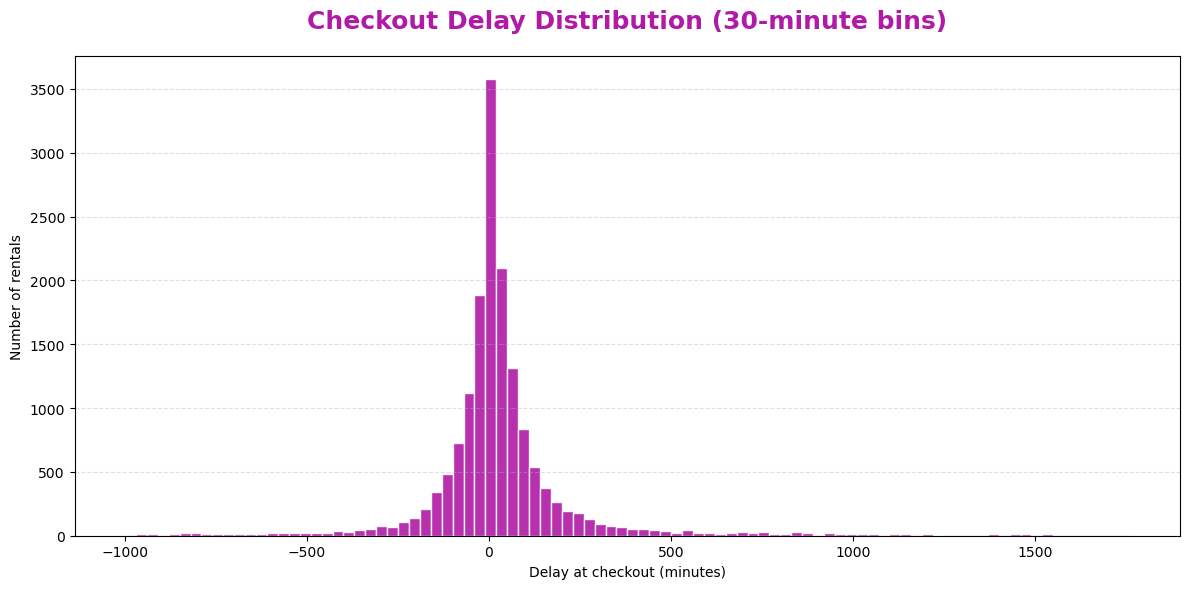

In [202]:
# Keep only ended rentals with valid delay
df_delay = df[(df["state"] == "ended") & (df["delay_at_checkout_in_minutes"].notna())].copy()

delays = df_delay["delay_at_checkout_in_minutes"]

# Define zoom range
lower = -1000
upper = 1750

filtered_delays = delays[(delays >= lower) & (delays <= upper)]

# Create 30-minute bins
bin_width = 30
bins = np.arange(lower, upper + bin_width, bin_width)

plt.figure(figsize=(12, 6))
plt.hist(filtered_delays, bins=bins, color="#B01AA7", edgecolor="white", alpha=0.9)

plt.title(
    "Checkout Delay Distribution (30-minute bins)",
    fontsize=18,
    fontweight="bold",
    color="#B01AA7",
    pad=20
)

plt.xlabel("Delay at checkout (minutes)")
plt.ylabel("Number of rentals")
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


This histogram shows the distribution of checkout delays in 30-minute bins.  
Negative values correspond to early returns, while positive values represent late returns.

Most returns occur close to the expected checkout time, but there is a significant long tail of late returns extending over several hours. Early returns are also frequent, showing that many users bring back the car in advance.


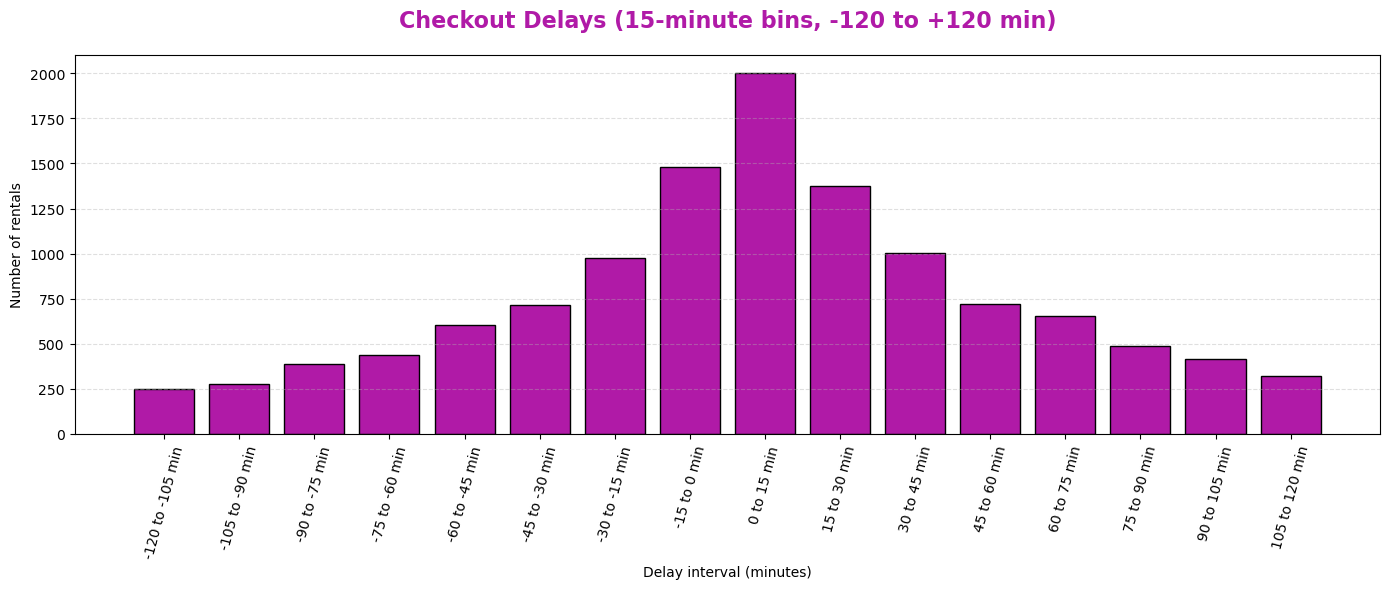

In [203]:
# Filter: ended rentals with valid delay
df_delay = df[(df["state"] == "ended") & (df["delay_at_checkout_in_minutes"].notna())].copy()
delays = df_delay["delay_at_checkout_in_minutes"]

# Time window: -120 to +120 min
lower, upper = -120, 120
filtered = delays[(delays >= lower) & (delays <= upper)]

# 15-minute bins
bin_width = 15
bins = np.arange(lower, upper + bin_width, bin_width)

# Compute histogram counts
counts, bin_edges = np.histogram(filtered, bins=bins)

# Create readable labels for each interval
labels = [f"{int(bin_edges[i])} to {int(bin_edges[i+1])} min" for i in range(len(bin_edges)-1)]

# Build DataFrame without sorting (natural time order preserved)
hist_df_ordered = pd.DataFrame({"interval": labels, "count": counts})

# Plot
plt.figure(figsize=(14, 6))
plt.bar(hist_df_ordered["interval"], hist_df_ordered["count"],
        color="#B01AA7", edgecolor="black")

plt.xticks(rotation=75)
plt.title("Checkout Delays (15-minute bins, -120 to +120 min)",
          fontsize=16, fontweight="bold", color="#B01AA7", pad=20)
plt.ylabel("Number of rentals")
plt.xlabel("Delay interval (minutes)")
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


This histogram displays the number of rentals returned in each 15-minute interval within a ±2-hour window.  
The bars are ordered chronologically: early returns (negative delays) appear on the left, and late returns (positive delays) on the right.  
Most checkouts occur close to the expected time, with fewer rentals at the extremes of the 2-hour window.


### Delays Between 2 Hours and 24 Hours

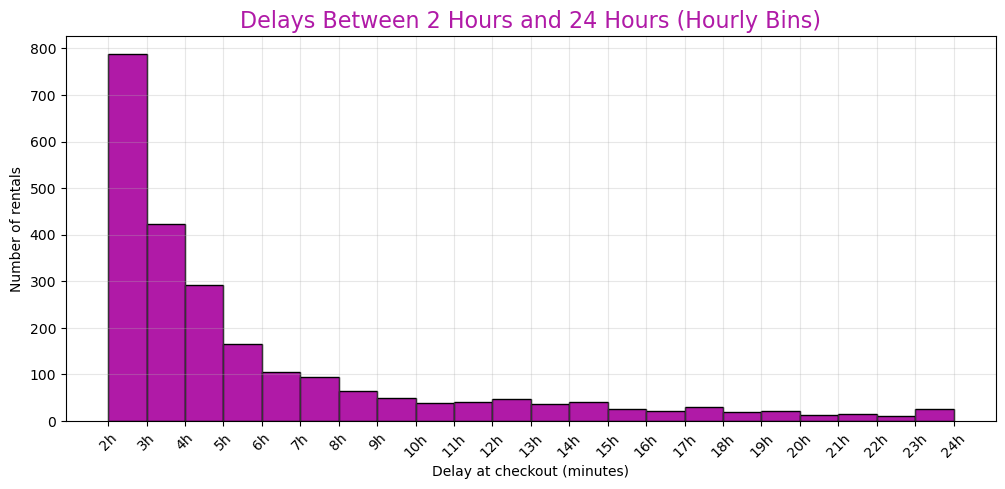

In [204]:
# Filter delays between 2h and 24h
df_mid = df_delay[
    (df_delay["delay_at_checkout_in_minutes"] > 120) &
    (df_delay["delay_at_checkout_in_minutes"] <= 1440)
]

# Create hourly bins: 120, 180, 240, ..., 1440
bins = np.arange(120, 1500, 60)

plt.figure(figsize=(12,5))
plt.hist(df_mid["delay_at_checkout_in_minutes"], bins=bins, color="#B01AA7", edgecolor="black")

plt.title("Delays Between 2 Hours and 24 Hours (Hourly Bins)", fontsize=16, color="#B01AA7")
plt.xlabel("Delay at checkout (minutes)")
plt.ylabel("Number of rentals")

# Add grid
plt.grid(alpha=0.3)

# Display the ticks in hours for clarity
plt.xticks(bins, [f"{i//60}h" for i in bins], rotation=45)

plt.show()


Medium delays (2–3 hours) are relatively frequent, representing around 4% of all rentals. However, most of them do not cause operational conflicts because no next rental is scheduled shortly after. Only 0.8% of all rentals generate an actual conflict, showing that the real issue is not the existence of delays, but the combination of delays and tight scheduling.

### Distribution of Late Returns (0h to 24h)

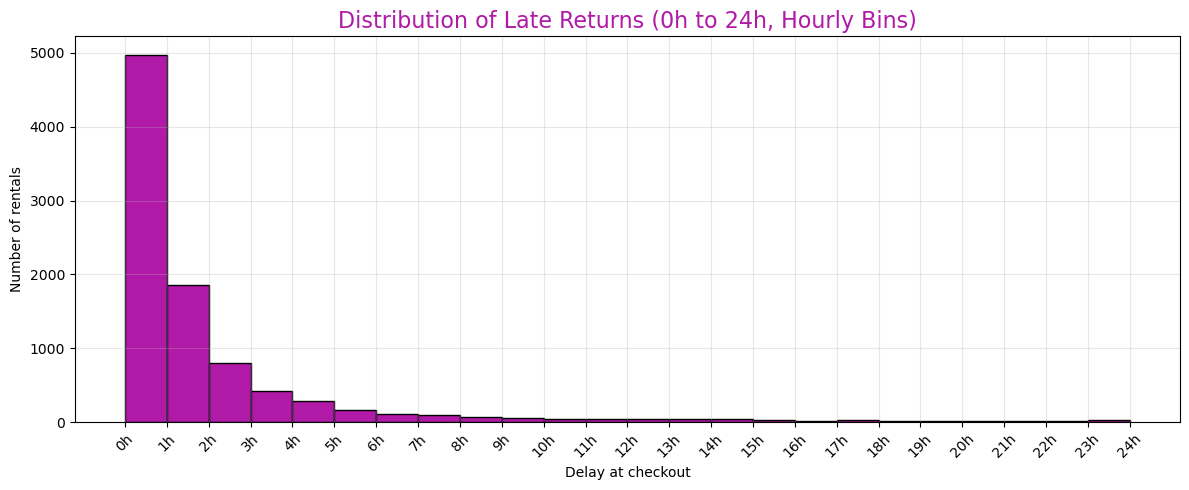

In [205]:
# Keep only rentals with delay (positive delays only)
df_late = df_delay[df_delay["delay_at_checkout_in_minutes"] > 0]

# Hourly bins from 0 min to 1440 min (24h)
bins = np.arange(0, 1441, 60)  # 0, 60, 120, ..., 1440

plt.figure(figsize=(12, 5))

plt.hist(
    df_late["delay_at_checkout_in_minutes"],
    bins=bins,
    color="#B01AA7",
    edgecolor="black"
)

plt.title("Distribution of Late Returns (0h to 24h, Hourly Bins)",
          fontsize=16, color="#B01AA7")

plt.xlabel("Delay at checkout")
plt.ylabel("Number of rentals")
plt.grid(alpha=0.3)

# X-axis labels in hours for clarity
plt.xticks(
    bins,
    [f"{i//60}h" for i in bins],
    rotation=45
)

plt.tight_layout()
plt.show()


Most late returns occur within the first two hours, but there is a noticeable secondary peak between 2h and 3h. Beyond 3h, the number of late returns drops sharply. This unified view confirms that medium delays (2–3 hours) are relatively common, while longer delays become increasingly rare.

### Delays greater than 24 hours (1440 minutes)

In [206]:
# Filter delays greater than 24 hours (1440 minutes)
df_extreme = df_delay[df_delay["delay_at_checkout_in_minutes"] > 1440]

# Count them
extreme_count = len(df_extreme)
extreme_count


188

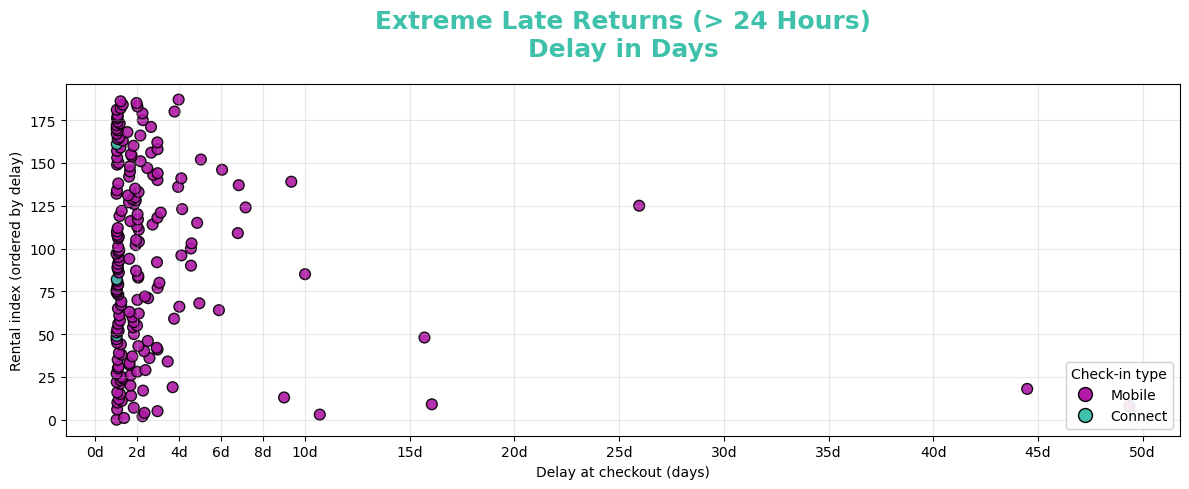

In [207]:
from matplotlib.lines import Line2D

# Filter delays greater than 24 hours
df_extreme = df_delay[df_delay["delay_at_checkout_in_minutes"] > 1440].copy()

# Convert delay to days
df_extreme["delay_days"] = df_extreme["delay_at_checkout_in_minutes"] / (60 * 24)

# Assign colors by checkin_type
color_map = {
    "mobile": "#B01AA7",   # violet
    "connect": "#40C1AC"   # turquoise
}
colors = df_extreme["checkin_type"].map(color_map)

plt.figure(figsize=(12, 5))

plt.scatter(
    df_extreme["delay_days"],
    range(len(df_extreme)),
    color=colors,
    edgecolor="black",
    alpha=0.9,
    s=60
)

plt.title(
    "Extreme Late Returns (> 24 Hours)\nDelay in Days",
    fontsize=18, fontweight="bold",
    color="#40C1AC",
    pad=20
)

plt.xlabel("Delay at checkout (days)")
plt.ylabel("Rental index (ordered by delay)")
plt.grid(alpha=0.3)

# ============================
# Custom X-axis ticks
# ============================

max_days = df_extreme["delay_days"].max()

ticks_2d = list(range(0, min(10, int(max_days)) + 1, 2))
ticks_5d = list(range(10, int(max_days) + 5, 5))
xticks = sorted(set(ticks_2d + ticks_5d))

plt.xticks(xticks, [f"{t}d" for t in xticks])

# ============================
# Legend (Mobile vs Connect)
# ============================

legend_elements = [
    Line2D([0], [0], marker="o", color="w",
           markerfacecolor="#B01AA7", markeredgecolor="black",
           markersize=10, label="Mobile"),
    Line2D([0], [0], marker="o", color="w",
           markerfacecolor="#40C1AC", markeredgecolor="black",
           markersize=10, label="Connect")
]

plt.legend(
    handles=legend_elements,
    title="Check-in type",
    loc="lower right",
    frameon=True,
    framealpha=0.9
)

plt.tight_layout()
plt.show()


Extreme delays above 24 hours form a scattered distribution, with most cases between 1 and 3 days late and a few extreme outliers exceeding several days. Although rare, each of these events is highly disruptive and can affect multiple subsequent rentals.

## Time delta with previous rental

In [208]:
# Number of non-null values in the column
non_null = df["time_delta_with_previous_rental_in_minutes"].notna().sum()

# Number of null values
null = df["time_delta_with_previous_rental_in_minutes"].isna().sum()

# Total rows
total = len(df)

non_null, null, total


(1841, 19469, 21310)

Only 1841 rentals have a time_delta_with_previous_rental_in_minutes value.
These are the rentals that happened less than 12 hours after a previous one, meaning they are the only cases where a late return can impact the next driver.
The remaining 19,469 rentals have NULL because the previous rental was either too far in the past or didn’t exist.

### Distribution of Time Delta Between Rentals (<12h)

In [209]:
sorted(df["time_delta_with_previous_rental_in_minutes"].dropna().unique())

[0.0,
 30.0,
 60.0,
 90.0,
 120.0,
 150.0,
 180.0,
 210.0,
 240.0,
 270.0,
 300.0,
 330.0,
 360.0,
 390.0,
 420.0,
 450.0,
 480.0,
 510.0,
 540.0,
 570.0,
 600.0,
 630.0,
 660.0,
 690.0,
 720.0]

We can see they calculate it every 30 minutes.

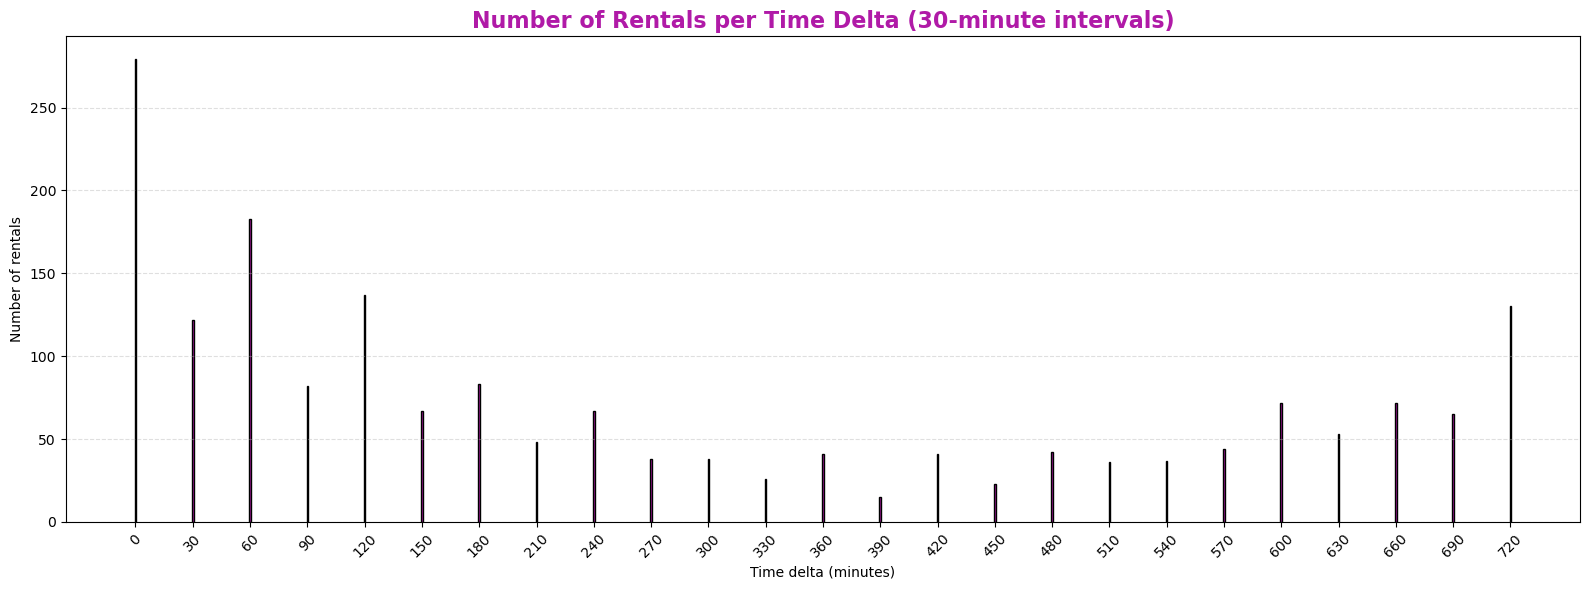

In [210]:
# Keep valid values
df_delta = df[df["time_delta_with_previous_rental_in_minutes"].notna()].copy()

# Count per unique time_delta
value_counts = df_delta["time_delta_with_previous_rental_in_minutes"].value_counts().sort_index()

plt.figure(figsize=(16, 6))
plt.bar(value_counts.index, value_counts.values,
        color="#B01AA7", edgecolor="black")

plt.title("Number of Rentals per Time Delta (30-minute intervals)",
          fontsize=16, fontweight="bold", color="#B01AA7")

plt.xlabel("Time delta (minutes)")
plt.ylabel("Number of rentals")

# One tick per interval
plt.xticks(value_counts.index, rotation=45)

plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


This histogram shows how close rentals are scheduled to each other.
Most of the 1841 back-to-back rentals fall within short time windows, which increases the risk of delay propagation.

### Time Delta Distribution by Check-in Type

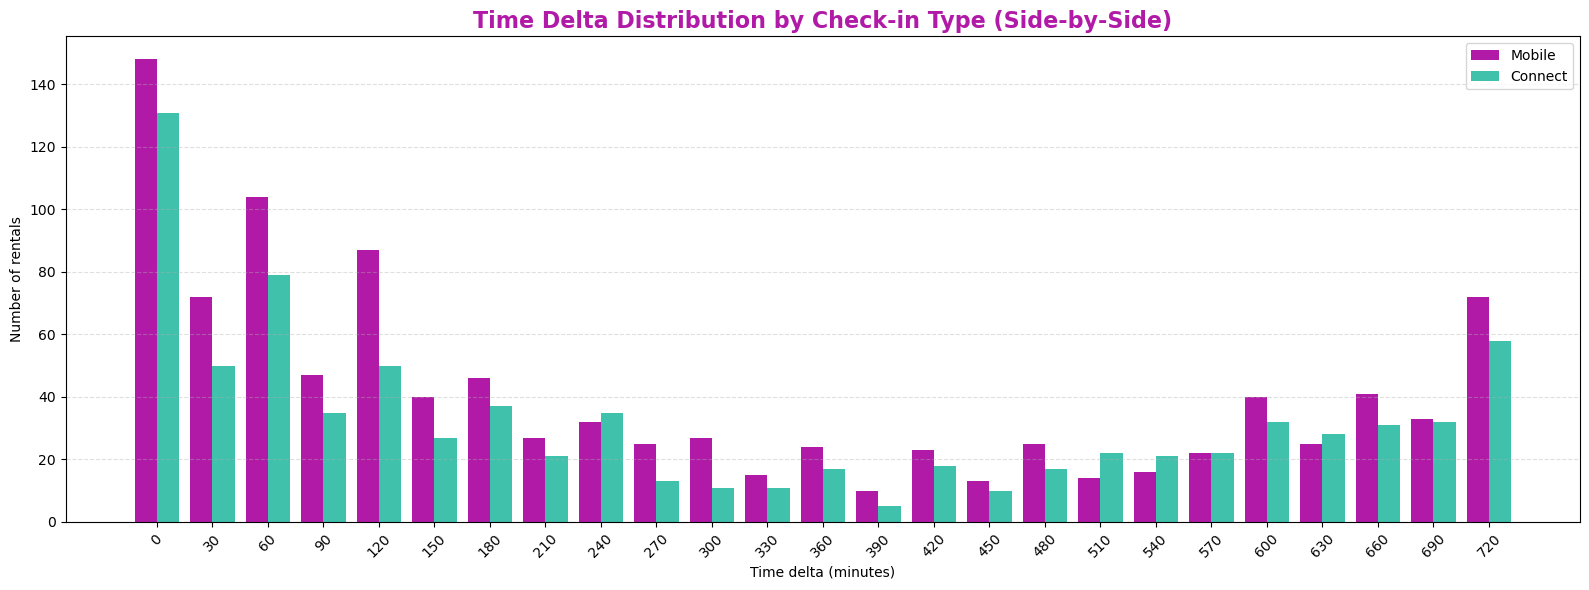

In [ ]:
# Keep only valid time delta values
df_delta = df[df["time_delta_with_previous_rental_in_minutes"].notna()].copy()

# Group by delta and checkin_type
grouped = df_delta.groupby(
    ["time_delta_with_previous_rental_in_minutes", "checkin_type"]
).size().unstack(fill_value=0)

# Ensure sorted order
grouped = grouped.sort_index()

# Values
x = np.arange(len(grouped))  # positions
width = 0.4                  # bar width

plt.figure(figsize=(16, 6))

plt.bar(x - width/2, grouped["mobile"], width, 
        label="Mobile", color="#B01AA7")
plt.bar(x + width/2, grouped["connect"], width, 
        label="Connect", color="#40C1AC")

plt.xticks(x, grouped.index.astype(int), rotation=45)
plt.xlabel("Time delta (minutes)")
plt.ylabel("Number of rentals")
plt.title("Time Delta Distribution by Check-in Type (Side-by-Side)", 
          fontsize=16, fontweight="bold", color="#B01AA7")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


Mobile rentals clearly dominate every 30-minute time-delta interval. This is expected since Mobile represents the vast majority of bookings in the dataset. Connect remains consistently lower but follows the same overall shape, meaning both check-in types experience similar gap patterns. Zero-minute gaps are heavily dominated by Mobile bookings, confirming that most tight turnarounds occur with traditional check-ins rather than Connect cars.

## Detect real problematic rentals

A situation is problematic when: previous_delay > time_delta
= the previous user was late more than the gap
→ so the next driver could not start on time.

In [212]:
# 1. Keep only rentals that actually ended and have a delay value

df_delay = df[
    (df["state"] == "ended") & 
    (df["delay_at_checkout_in_minutes"].notna())
].copy()

# At this stage:
# - Canceled rentals are removed (they do not have checkout delay)
# - Rows with missing delay are removed
# => df_delay contains ONLY valid completed rentals with delay info


# 2. Merge the delay from the previous rental onto the current rental row
df_merge = df_delay.merge(
    df_delay[["rental_id", "delay_at_checkout_in_minutes"]],  # right table: rental_id + delay
    left_on="previous_ended_rental_id",                       # match current rental’s 'previous_ended_rental_id'
    right_on="rental_id",                                     # to the actual rental_id in the dataset
    how="left",
    suffixes=("", "_previous")                                # delay from previous rental becomes '..._previous'
)

# Result:
# Each row now has:
# - delay_at_checkout_in_minutes → delay of current rental
# - delay_at_checkout_in_minutes_previous → delay of the previous rental (if any)


# 3. Keep only the rentals that actually have a previous rental
df_chain = df_merge[
    df_merge["delay_at_checkout_in_minutes_previous"].notna()
].copy()

# Rows where previous rental delay is NaN means:
# - no previous rental, OR
# - previous rental was too far in the past (>12 hours)
# => These can never create a conflict, so we drop them


# 4. Identify “problematic” cases
df_chain["problematic"] = (
    df_chain["delay_at_checkout_in_minutes_previous"] >   # previous driver was late
    df_chain["time_delta_with_previous_rental_in_minutes"]  # available gap between rentals
)

# Meaning:
# A case is problematic if the previous delay is LONGER than the time gap.
# Example:
# - Previous delay = 60 minutes
# - Gap = 30 minutes
# => Problematic = True (the next driver will be impacted)


# 5. Count how many problematic cases there are
problematic_count = df_chain["problematic"].sum()
total_chains = len(df_chain)

# problematic_count = number of conflicts caused by late previous driver
# total_chains = total number of consecutive rentals analyzed

problematic_count, total_chains


(172, 1476)

This calculation gives how many rentals were actually impacted by a late previous user out of the 1841 possible chain rentals.

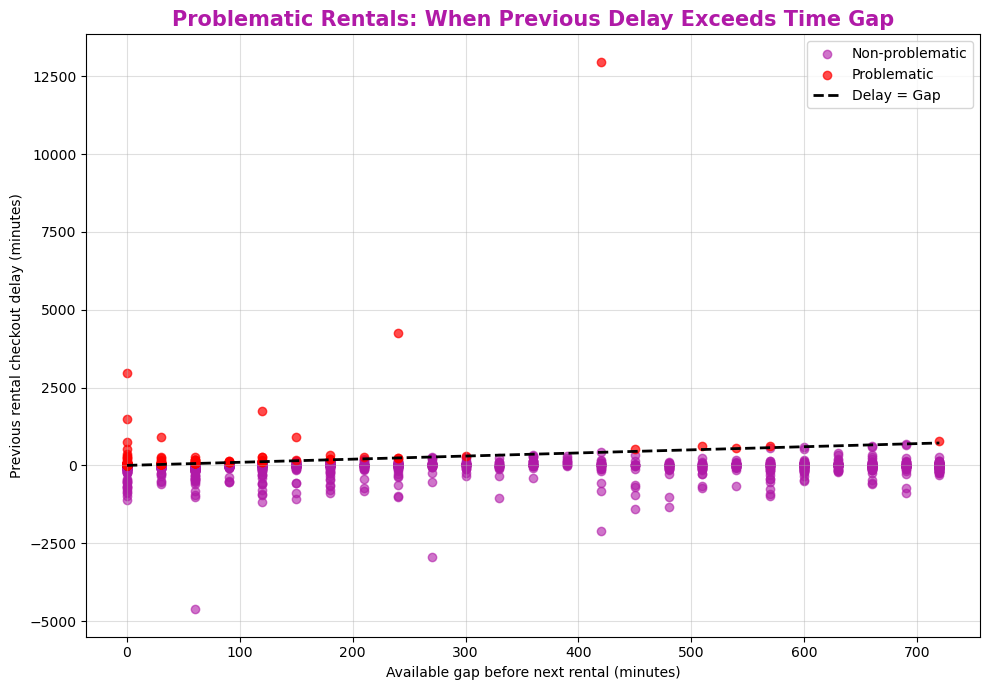

In [213]:
# We assume df_chain already exists (from your previous code)
df_chain = df_chain.copy()

plt.figure(figsize=(10, 7))

# Plot non-problematic cases
plt.scatter(
    df_chain[df_chain["problematic"] == False]["time_delta_with_previous_rental_in_minutes"],
    df_chain[df_chain["problematic"] == False]["delay_at_checkout_in_minutes_previous"],
    color="#B01AA7", alpha=0.6, label="Non-problematic"
)

# Plot problematic cases
plt.scatter(
    df_chain[df_chain["problematic"] == True]["time_delta_with_previous_rental_in_minutes"],
    df_chain[df_chain["problematic"] == True]["delay_at_checkout_in_minutes_previous"],
    color="red", alpha=0.7, label="Problematic"
)

# Add diagonal threshold
plt.plot(
    [0, df_chain["time_delta_with_previous_rental_in_minutes"].max()],
    [0, df_chain["time_delta_with_previous_rental_in_minutes"].max()],
    linestyle="--", color="black", linewidth=2,
    label="Delay = Gap"
)

plt.xlabel("Available gap before next rental (minutes)")
plt.ylabel("Previous rental checkout delay (minutes)")
plt.title(
    "Problematic Rentals: When Previous Delay Exceeds Time Gap",
    fontsize=15, fontweight="bold", color="#B01AA7"
)
plt.legend()
plt.grid(alpha=0.4)

plt.tight_layout()
plt.show()


This scatterplot compares the previous rental’s delay with the available time gap before the next booking.
Purple points represent safe cases where the delay is smaller than the time gap, while red points indicate conflicts where the previous delay exceeds the gap and impacts the next driver.
The diagonal line (delay = gap) naturally separates the safe zone from the conflict zone. Most conflicts cluster within short time gaps (under 60 minutes), showing that the platform structurally allows bookings that are too tightly chained. Moderate delays rarely cause issues when sufficient buffer time exists, suggesting that increasing the minimum time gap would significantly reduce conflicts without penalizing most rentals.

## Optimal Threshold Evaluation: Conflict Reduction Impact

In [214]:
def simulate_threshold_correct(threshold, df_chain):
    # Keep only the true problematic cases
    df_prob = df_chain[df_chain["problematic"] == True]
    
    # A conflict is solved if the previous delay is <= threshold
    solved = df_prob["delay_at_checkout_in_minutes_previous"] <= threshold
    
    return solved.sum(), len(df_prob)


thresholds = [0, 15, 30, 45, 60, 90, 120]

rows = []

for t in thresholds:
    solved, total = simulate_threshold_correct(t, df_chain)

    rows.append({
        "threshold": t,
        "conflicts_resolved": solved,
        "conflicts_total": total,
        "percent_resolved": (solved / total) * 100
    })

df_sim_correct = pd.DataFrame(rows)
df_sim_correct


,threshold,conflicts_resolved,conflicts_total,percent_resolved
0,0,0,172,0.000000
1,15,42,172,24.418605
2,30,60,172,34.883721
3,45,73,172,42.441860
4,60,86,172,50.000000
5,90,112,172,65.116279
6,120,124,172,72.093023


Increasing the minimum allowed gap between two rentals significantly reduces conflict cases (late return impacting the next driver). A 15-minute buffer resolves about 24% of conflicts, while a 30-minute threshold solves 35%. The effect becomes more meaningful at 60 minutes, with 50% of conflicts resolved. A 90-minute buffer solves about two thirds of all issues, and 120 minutes covers roughly 72%. This shows that small thresholds bring limited benefit, and the real operational improvement starts around 60–90 minutes.

## Impact of Minimum Gap Threshold on Conflict Resolution

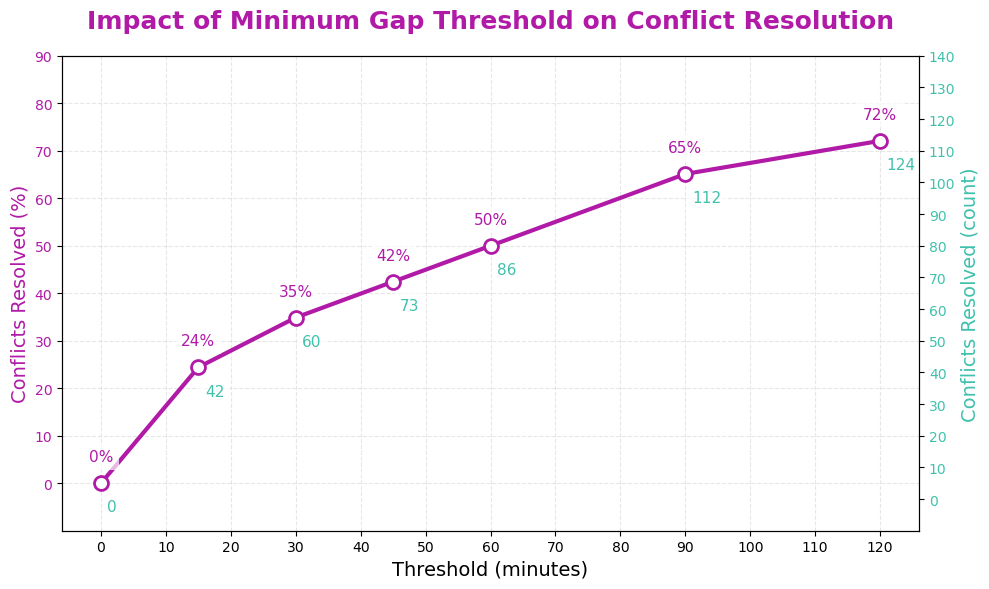

In [215]:
x = df_sim_correct["threshold"]               # Threshold values (in minutes)
p = df_sim_correct["percent_resolved"]        # Percentage of conflicts resolved
c = df_sim_correct["conflicts_resolved"]      # Absolute number of conflicts resolved

fig, ax1 = plt.subplots(figsize=(10, 6))

# Main curve (violet): percentage resolved 
ax1.plot(x, p, "o-", color="#B01AA7", markersize=10,
         markerfacecolor="white", markeredgewidth=2, linewidth=3)

# Left Y-axis (percent)
ax1.set_xlabel("Threshold (minutes)", fontsize=14)
ax1.set_ylabel("Conflicts Resolved (%)", fontsize=14, color="#B01AA7")
ax1.tick_params(axis="y", labelcolor="#B01AA7")
ax1.grid(alpha=0.3, linestyle="--")

# Right Y-axis (counts)
ax2 = ax1.twinx()
ax2.set_ylabel("Conflicts Resolved (count)", fontsize=14, color="#40C1AC")
ax2.tick_params(axis="y", labelcolor="#40C1AC")

# Expand axes for better visibility
ax1.set_ylim(-10, p.max() + 15)
ax2.set_ylim(-10, c.max() + 15)
ax1.set_yticks(np.arange(0, p.max() + 20, 10))
ax2.set_yticks(np.arange(0, c.max() + 20, 10))
ax1.set_xticks(np.arange(0, x.max() + 10, 10))

# Annotations: Percentage & Count labels
for xi, yp, yc in zip(x, p, c):
    ax1.text(xi, yp + 4, f"{yp:.0f}%", ha="center", va="bottom",
             fontsize=11, color="#B01AA7",
             bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))
    ax1.text(xi + 1, yp - 5, str(int(yc)), ha="left", va="center",
             fontsize=11, color="#40C1AC",
             bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

# Title
plt.title("Impact of Minimum Gap Threshold on Conflict Resolution",
          fontsize=18, fontweight="bold", color="#B01AA7", pad=20)

plt.tight_layout()
plt.show()


## Early Returns

In [216]:
# Keep only early returns (delay < 0)
df_early = df_delay[df_delay["delay_at_checkout_in_minutes"] < 0].copy()

len(df_early)


6819

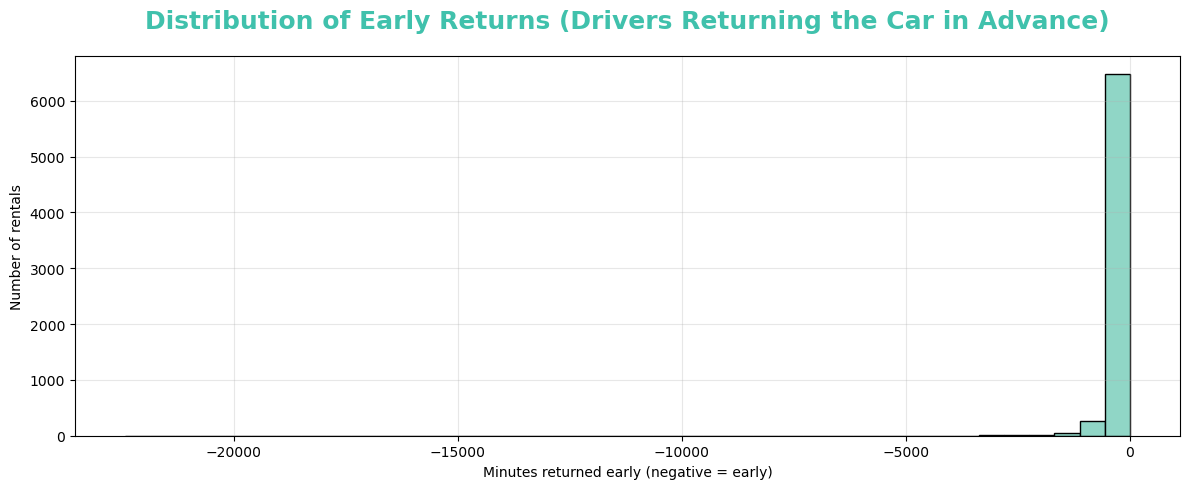

In [217]:
# Extract advance in minutes (negative values)
early = df_early["delay_at_checkout_in_minutes"]

plt.figure(figsize=(12, 5))

plt.hist(
    early,
    bins=40,
    color="#90D6C6",   # vert doux
    edgecolor="black"
)

plt.title(
    "Distribution of Early Returns (Drivers Returning the Car in Advance)",
    fontsize=18, fontweight="bold", color="#40C1AC", pad=20
)

plt.xlabel("Minutes returned early (negative = early)")
plt.ylabel("Number of rentals")

plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


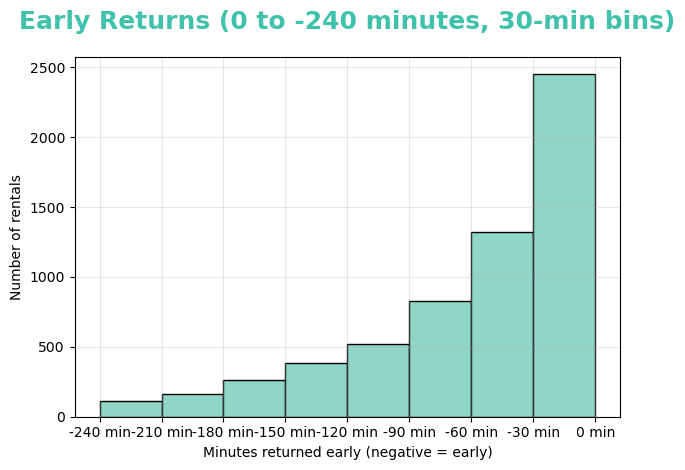

In [218]:
# Keep only early returns (delay < 0)
df_early = df_delay[df_delay["delay_at_checkout_in_minutes"] < 0].copy()

early = df_early["delay_at_checkout_in_minutes"]

# Bins from -240 to 0 in steps of 30 minutes
bins = np.arange(-240, 1, 30)

plt.hist(
    early,
    bins=bins,
    color="#90D6C6",
    edgecolor="black"
)

plt.title(
    "Early Returns (0 to -240 minutes, 30-min bins)",
    fontsize=18,
    fontweight="bold",
    color="#40C1AC",
    pad=20
)

plt.xlabel("Minutes returned early (negative = early)")
plt.ylabel("Number of rentals")
plt.grid(alpha=0.3)

plt.xticks(bins, [f"{b} min" for b in bins])

plt.tight_layout()
plt.show()


Early returns are surprisingly frequent: many drivers bring the car back ahead of the scheduled checkout time, often by 10 to 60 minutes. While early returns do not help resolve conflicts caused by late returns, they show that a large share of users behave responsibly or even proactively. This pattern could be used to reward good behavior or improve customer experience.

## Distribution of Time Gaps Between Consecutive Rentals

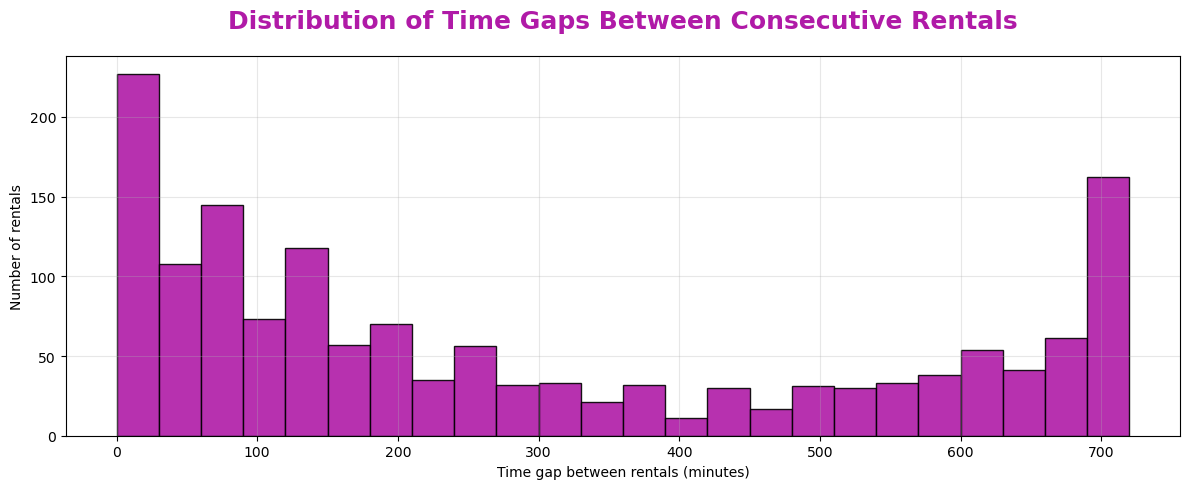

In [219]:
df_delta = df_delay[df_delay["time_delta_with_previous_rental_in_minutes"].notna()].copy()

# Values
gaps = df_delta["time_delta_with_previous_rental_in_minutes"]

plt.figure(figsize=(12, 5))

plt.hist(
    gaps,
    bins=24,                 # 24 bins = 0 à 720 min (~12h), 1 bin par tranche de 30 min
    color="#B01AA7",
    edgecolor="black",
    alpha=0.9
)

plt.title(
    "Distribution of Time Gaps Between Consecutive Rentals",
    fontsize=18,
    fontweight="bold",
    color="#B01AA7",
    pad=20
)

plt.xlabel("Time gap between rentals (minutes)")
plt.ylabel("Number of rentals")

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


The distribution shows two structural patterns:
(1) many rentals are scheduled very closely together (0–60 minutes), creating high conflict risk;
(2) a second cluster appears around 10–12 hours, which corresponds to overnight idle time.
The mid-range gaps (2h–8h) are relatively rare, meaning that rentals are either tightly chained or separated by a full night.

## Summary & Recommendation

- Most rentals are booked with very short gaps (0–60 minutes) or overnight gaps (10–12 hours).
- Late returns are frequent but only a small fraction (≈0.8% of all rentals) actually creates a conflict with the next driver.
- Real conflicts occur when the previous delay exceeds the time gap, mostly within gaps under 60 minutes.
- A 60-minute minimum gap resolves about 50% of conflicts; 90 minutes resolves about 65%, and 120 minutes up to 72%.

**Recommendation:**  
Introduce a minimum buffer of **60 to 90 minutes** between consecutive rentals, especially for **Mobile check-ins**, where tight turnarounds are most common. This would significantly reduce customer friction while preserving most of the platform's revenue potential.

